# <center> **Лекция 2:** Теория компьютерного зрения. Цифровая обработка изображений. Извлечение признаков и поиск. </center>
----
<br>
</br>

<center> <img src=./../src/imgs/biased_cv.png> </center>

<br>
</br>


----

__План на сегодня:__
1. _Анализ главных компонент в задачах комьютерного зрения._
2. _Представление свойств и признакового пространства изображения с помощью гистограмм:_
    - Гистограммы цветов/цветовой схемы.
    - Гистограммы градиентов.
3. _Характеристические точки изображения:_
    - Поиск характеристических точек на изображении.
    - Выделение признаков (дескрипторов) характерных областей на изображении.
    - Матчинг/Сопоставление характеристических точек на изображениях.
4. _Поиск изображений по контенту CBIR:_
    - Выделение признаков и индексация.
    - Обзор архитектуры.
    - Поиск по индексу.

----

В каких задачах полученные знания будут полезны:

#### 1. Primitive Face Detection (Распознование лиц):
![](./../src/imgs/facedetection.png)

#### 2.Optical Flow Recognition (Распознование Оптического потока на изображениях):
![](./../src/imgs/opticalflowrecognition.png)

#### 3.Поиск похожих изображений (CBIR задача - Content Based Image Retrieval):
![](./../src/imgs/similart_imgs.png)

# Часть 1.
----

#### Начнем разговор об уже известном вам алгоритме PCA (__Principal Component Analysis__), он же - Анализ Главных Компонент, он же - алгоритм понижения размерности.

Как работает данный алгоритм?
<br>
</br>

![](./../src/imgs/PCA_cheatsheet.png)

<br>
</br>

----

__Применение в компьютерном зрении - задача детекта похожих картинок (лиц, изображений и прочих объектов):__

PCA - анализ главных компонент:
- Изображение можно представить в виде вектора длины HxW
- Большая размерность данных (число пикселей) затрудняет обработку
- Для сокращения размерности применяется метод PCA.
- В результате преобразования PCA получаем на выходе представление (-ия) изображений в базисе меньшей размерности.
- Полученное сжатое представление можно использовать для целей распознования изображений.


__Пример из жизни:__

Допустим у вас в базе есть сотни репрезентативных картинок для представления лица 1-го человека:
<br>
</br>

![](./../src/imgs/samepersonface.png)

<br>
</br>

Само изображение можно закодировать некоторым более оптимальным способом, нежели чем хранить всю совокупность картинок.
В чем практический смысл - так как это один и тот же человек в базе, то между собой изображения очень сильно похожи. Эту похожесть можно использовать для того, чтобы сжать наше представление огромного количества картинок до более оптимального размера с минимальными потерями признакового пространства.

Что мы здесь можем предпринять:
 А что если мы найдем такие изображения, которые возможно не будут соответствовать каким-либо изображениям в базе, но с помощью которых мы всегда можем и будем способны "восстановить" исходное изображение. То есть, как показано ниже, реализуем некоторые слепки изображений (которые называются базисными изображениями и будем взвешивать их с некоторыми весовыми коэффициентами для того, чтобы перейти в пространство исходного изображения. Количество собственных значений определяется рангом матрицы изображений, которое находится в базе (как правило, но есть исключения).
<br>
</br>

![](./../src/imgs/pca_imgs.png)

<br>
</br>

Чуть более формально задачу представления изображений можно описать в виде следующей схемы:
* У нас есть L базис векторов.
* Имеем N-ое количество картинок.
* На выходе получаем PCA представление N-го количества изображений (те самые коэффициенты q).
<br>
</br>

![](./../src/imgs/pca_repr.png)

<br>
</br>

----

__PCA - последовательность вычислений:__
1. Подготавливаем данные, представляем изображения в виде векторов длиной HxW, где H (строки) - количество изображений в нашей БД, а W (столбцы) - пиксели нашего отдельного изображения.
2. Строим матрицу ковариации между признаками.
3. Вычитаем среднее значение из каждой компоненты вектора.
4. Получаем собственные вектора в результате SVD разложения ковариационной матрицы изображений.
5. Выбираем размерность (количество собственных векторов) на основе этих значений.



### _Практическая реализация понижения размерности с помощью алгоритма PCA:_

In [56]:
import numpy
import cv2
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings('ignore')

Рассмотрим классический MNIST (датасет с ЧБ цифрами), который представлен в виде csv файла:

In [57]:
# загружаем данные
train = np.loadtxt('./../data/digit/train.csv', delimiter=',', skiprows=1)
# Сохраняем класс в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обработки виду
train_imgs = np.reshape(train[:, 1:], (len(train[:, 1:]), 28, 28))

Посмотрим как это все выглядит визуально:

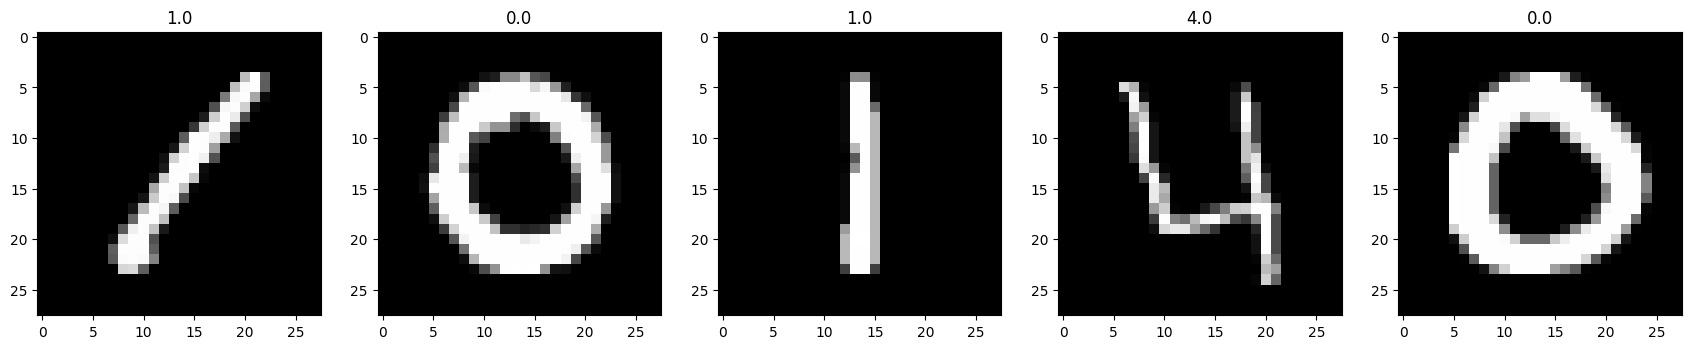

In [58]:
fig = plt.figure(figsize=(30, 10))

for i, img in enumerate(train_imgs[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1])

In [59]:
# Для простоты реализации выберем сэмпл данных для реализации алгоритма
choices = np.random.choice(train_imgs.shape[0], 10000)

y = train_label[choices]
X = train_imgs[choices].reshape(-1, 28 * 28).astype(np.float32)

In [60]:
# центрируем данные
X_mean = X.mean(axis=0)
X -= X_mean

![](./../src/imgs/covariance.png)

In [61]:
# матрица ковариации признаков
cov = np.dot(X.T, X) / X.shape[0]

In [62]:
# U - собсвенные вектора матрицы ковариации
# S - собственные значения (сколько дисперсии объясняет каждый собственный вектор)
U, S, _ = np.linalg.svd(cov)

Собственные числа:

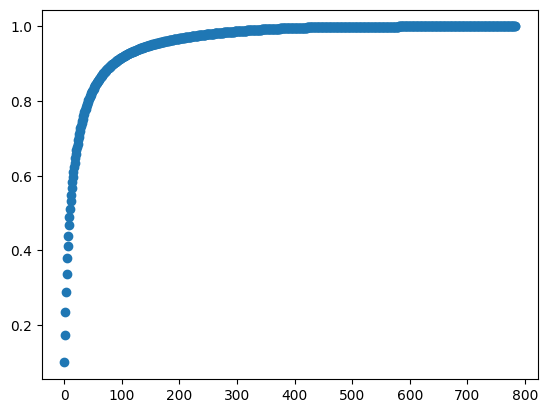

In [63]:
# накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

In [64]:
for i in range(5):
    print('[%03d] %.3f' % (i, S_cumsum[i]))

[000] 0.099
[001] 0.173
[002] 0.235
[003] 0.288
[004] 0.337


Понижаем размерность

In [75]:
S_thr = 0.9  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=85 S=0.901


In [76]:
# получаем сжатое представление объектов
Xrot_reduced = np.dot(X, U[:, :n_comp])

Восстанавливаем изображение после понижения размерности

In [77]:
Xrot_restored = np.dot(Xrot_reduced, U[:,:n_comp].T)

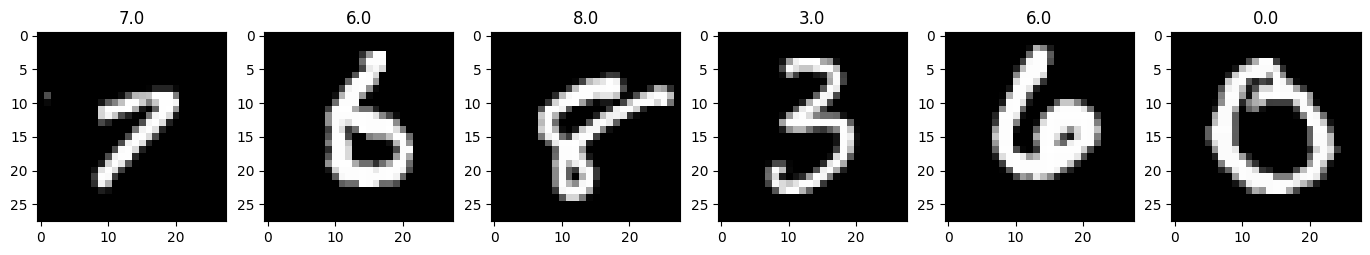

In [78]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(X[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + X_mean
    plt.title('%s' % y[i-1])
    plt.imshow(img_.reshape((28,28)), cmap='gray')

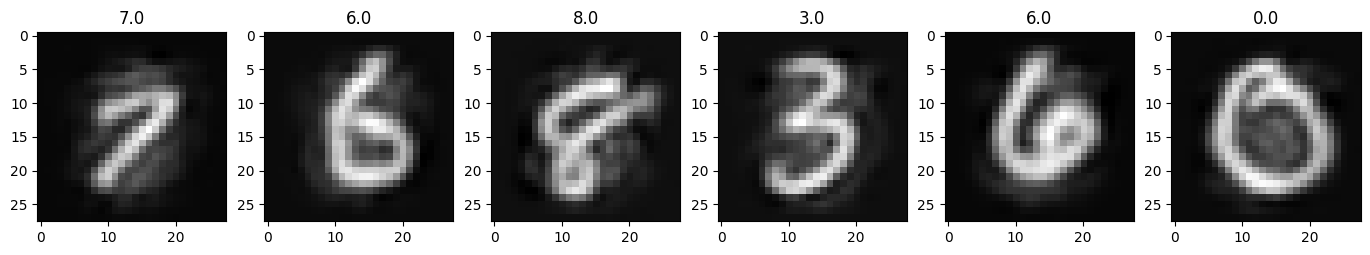

In [79]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(Xrot_restored[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + X_mean
    plt.title('%s' % y[i-1])
    plt.imshow(img_.reshape((28,28)) + X_mean.reshape((28,28)), cmap='gray')

Визуализация собственных векторов

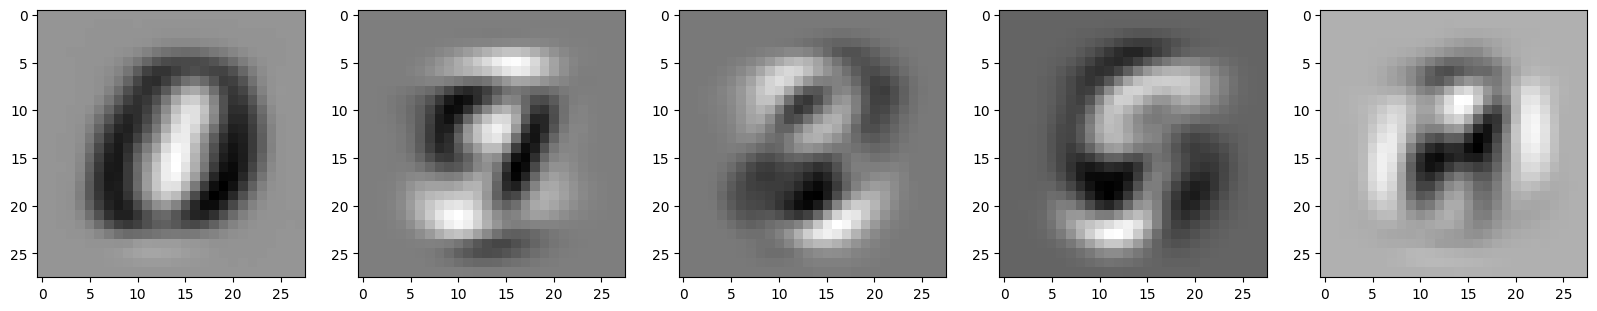

In [80]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(U.T[:5, :], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img.reshape((28,28)), cmap='gray');

# Часть 2: Выделение признаков изображения:
----
PCA - не единственный способ сжать и получить признаки изображения. В нашем инструментарии еще есть такой способ как описать гистограммы признаков изображения, то есть из своего же распределения признаков сформулировать какие-либо признаки.

Гистограммы признаков изображения:

* Представляют собой обобщенное описание изображения
* Как правило гистограммы инвариантны к масштабу и повороту изображений
* Позволяют сравнивать изображения и находить похожие


Существует множестов гистограмм признаков, но основные из них:
1. Гистограммы цветов изображения.
2. Гистограммы градиентов изображения (HOG).



### Гистограммы цветов изображения :
----

![](./../src/imgs/color_hist.png)



Суть заключается в следующем:
1. Разбиваем диапазон значений цвета (0, ..., 255) на фиксированное количество интервальных значений (интервальный значений), например с шагом 1.
2. Задаем в каких срезах (каналах) необходимо построить гистограмму.
3. Для каждого интервала считаем число соответствующих пикселей на изображении.
4. Можно вычислять как в пространстве RGB, так и других цветовых пространствах, например HSV (помним про количество каналов).

__Самый простой способ воспользоваться библиотекой OpenCV:__

```
cv2.calcHist(images, channels, mask, histSize, ranges) → hist
```

_где:_

__images__      – набор входных изображений для оценки гистограммы
__channels__    – каналы по которым оцениваются гистограммы
__mask__        – маска ограничивает область оценки гистограммы
__histSize__    – массив размеров гистограмм по каждому измерению
__ranges__      – диапазоны значений каждого измерения


_Отличительные особенности гистограммы цветов:_
1. Не зависят от изменения масштаба изображения.
2. Устойчивы к повороту и перспективным искажениям.
3. В цветовых пространствах HSV/HSL менее чувствительны к изменению яркости.

### Гистограммы градиентов изображения (HOG):
----

![](./../src/imgs/grad_hist.png)


Суть заключается в следующем:
1. В каждой точке оцениваем составляющие градиента по осям x и у.
2. Определяем направление и длину вектора градиента.
3. Оцениваем гистограмму градиентов.
4. Полученные гистограммы нормализуют таким образом, чтобы вектор признаков был единичной длины.

Как правило строят только для отдельного цветового канала.

Один из частных случаев гистограммы градиента цветов изображения - __Оператор Собеля__:

![](./../src/imgs/sobelsfilters.png)


Результат:

![](./../src/imgs/sobelsoperatorresult.png)


Рассчет градиентов реализован при помощи поиска:

![](./../src/imgs/hog_eq.png)

где,
$g, g_x, g_y$ - длина вектора градиента и его составляющих
$\theta$ - угол наклона градиента в полярной системе координат


Важные моменты, касаемо гистограмм градиентов:
1. Как правило, гистограмму градиентов строят для диапазона углов 0...180.
2. При оценке гистограммы градиентов учитывается как угол, так и длина вектора.
3. Чем больше длина вектора, тем больший вклад вносится в соответствующую ячейку гистограммы.

Что в итоге получится:

![](./../src/imgs/grad_hist_matrix.png)


Практическая реализация - как всегда OpenCV, а именно:

1. __Оператор Собеля:__
```
cv2.Sobel(src, ddepth, dx, dy[, dst[, ksize]]) → dst

    src – входное изображение
    ddepth - тип данных для вычисления производной, например, cv2.CV_64F
    dx/dy - порядок производной по осям, как правило 0 или 1
    dst - выходное изображение
    ksize – размер ядра фильтра 1, 3, 5, или 7
```

2. __Перевод в полярные координаты__:

```
cv2.cartToPolar(x, y) → magnitude, angle

    x,y – вектора с координатами x и y
    magnitude - длины векторов
    angle - соответствующие углы
```


Особенности гистограмм градиентов:
1. Не чувствительны к измеению цвета
2. Устойчивы к изменению яркости
3. Устойчивы к изменению масштаба


Существует еще метод Gabor Filters помимо перечисленных выше. Такие фильтры могут быть использованы для анализа ориентированных текстур и тоже могут учитывать градиенты нашего изображения. 

![](./../src/imgs/gabor_filter.png)

Практическая реализация гистограмм на MNIST:

In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

train = np.loadtxt('./../data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./../data/digit/test.csv', delimiter=',', skiprows=1)

In [82]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [83]:
train_img.shape

(42000, 28, 28)

Визуализируем исходные данные

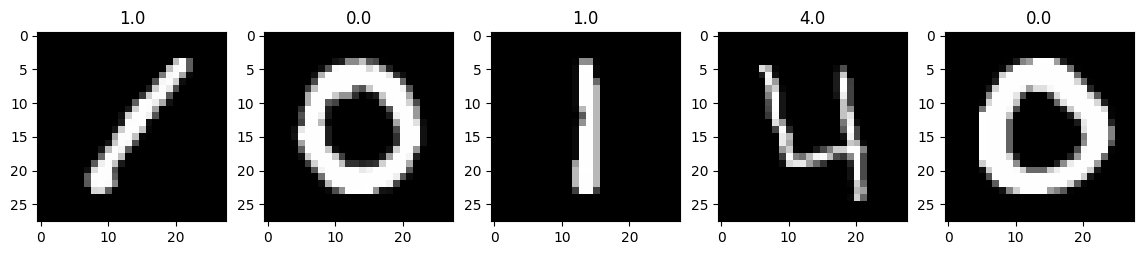

In [84]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [85]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)

for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [86]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)

for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

Вычисляем угол и длину вектора градиента

In [87]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [88]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

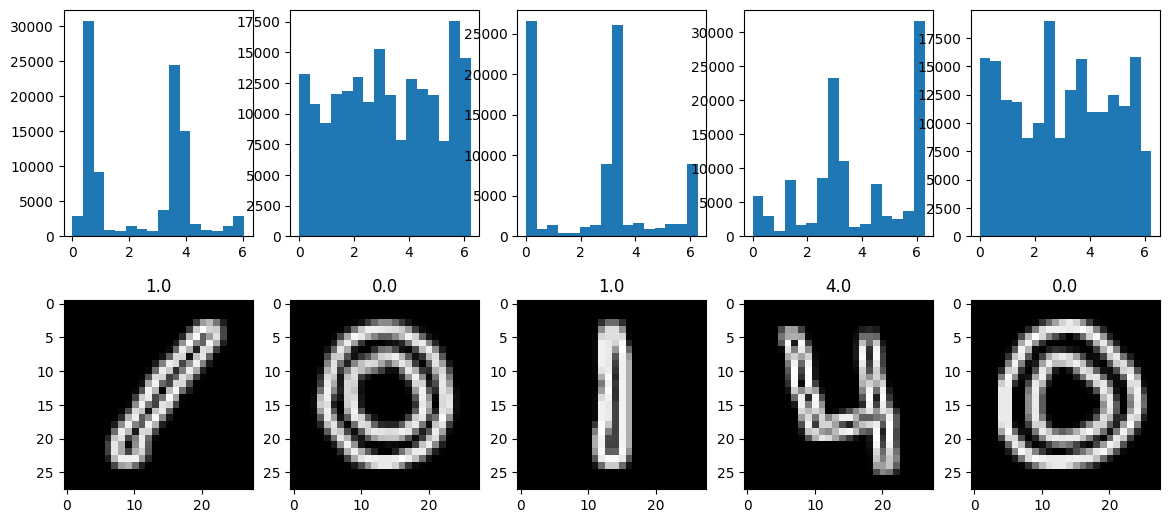

In [89]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

Вычисляем гистограммы градиентов

In [90]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):

    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [91]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):

    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

Нормируем вектор гистограммы

In [92]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [93]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

Разбиваем выборку на обучение и валидацию

In [94]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

Вычисляем центроиды каждого из 10 классов

In [95]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [96]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

Находим ближайший центройд для валидации

In [97]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

Оцениваем качество решение на валидационной выборке

In [98]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.4270238095238095


In [99]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.34      0.12      0.18       816
         1.0       0.59      0.76      0.66       909
         2.0       0.33      0.29      0.31       846
         3.0       0.55      0.49      0.51       937
         4.0       0.33      0.31      0.32       839
         5.0       0.46      0.67      0.55       702
         6.0       0.24      0.45      0.31       785
         7.0       0.73      0.41      0.53       893
         8.0       0.39      0.49      0.44       835
         9.0       0.48      0.27      0.34       838

    accuracy                           0.43      8400
   macro avg       0.44      0.43      0.42      8400
weighted avg       0.45      0.43      0.42      8400



In [100]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[102  24  82  30 106  18 221   7 179  47]
 [  0 692   2   0  44   1 139  17  13   1]
 [ 21   0 245 158  12 203  54  16 119  18]
 [ 14   0 113 456   3 235   7   2  98   9]
 [ 11 248   5   2 260   0 205  43  37  28]
 [  3   0  84  97   5 472   3   4  33   1]
 [ 53  26  66  11 116   4 355  13  76  65]
 [  4 113  38  16  66  41 189 368  15  43]
 [ 81   6  68  44  36  44 107   3 411  35]
 [ 11  73  31  20 149  11 222  30  65 226]]


Предсказания на тестовыйх данных

In [101]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

Визуализируем предсказания

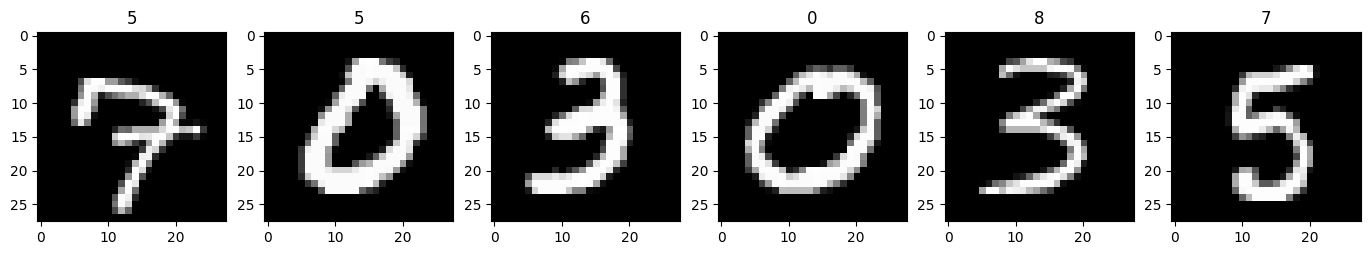

In [104]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[5:11], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

# Часть 3: Характеристические (характерные) точки изображения:
----

Характеристические точки изображения:
- Позволяют находить одинаковые области (предметы) на разных изображениях.
- Используются для склейки панорам и составления карт по спутниковым и космическим снимкам.

Характеристические точки:
1. Точка, обладающая уникальными свойствами
2. Положение точки на изображении однозначно определяется по ее свойствам (дескриптору)
3. Дескриптор точки вычисляется на основе ее окружения
4. Дескриптор характерной точки инвариантен к изменениям изображения (освещенность, поворот, масштабирование, обрезка)


![](./../src/imgs/characteristic_points.png)



__Этапы поиска и матчинга характеристических точек__:
1. Определяем области на изображении, которые наиболее вероятно содержат характерную точку;
2. Вычисляем дескрипторы точки по каждой из областей;
3. Находим точки с одинаковыми дескрипторами для матчинга изображений


__Поиск характерной точки на изображении__:
– Как понять что выбранная область содержит характерную точку?
– Область вокруг характерной точки должна сильно варьироваться;
– В области характерной точки небольшой сдвиг изображения должен приводить к существенному различию по сравнению с исходным изображением.


### Автокорреляция:

![](./../src/imgs/autocorr.png)


где,
$\delta_u$ - вектор смещения по осям x и у
$x_i$ - вектор координат пикселя изображения
$w$ - окно или фильтр (обычно гауссовский)
$I_o$ - исходное изображение

### Матрица Автокорреляции:

![](./../src/imgs/autocroo_matrix.png)

<br>
</br>

![](./../src/imgs/autocorr_matrix_2.png)

<br>
</br>

В случае нескольких каналов:

<br>
</br>

![](./../src/imgs/autocorr3d.png)

### Поиск характеристической точки (области) на изображении:
– необходима количественная мера для поиска области с характерной точкой;
– большая часть мер основана на собственных чисел матрицы автокорреляции в анализируемой области;
– тк область вокруг точки должна сильно варьироваться, то нас интересуют области с большими значениями собственных чисел матрицы автокорреляции

### Шаги:
1. Строим автокорреляционную матрицу изображения;
2. Для каждой точки изображения вычисляем собственные числа в соответствующей окрестности матрицы автокорреляции;
3. Оставляем точки с локальным максимумом меры (Non-Maximum Suppression);
4. Полученные области содержат характерные точки

# Алгоритмы вычисления декрипторов:

## SIFT — Scale Invariant Feature Transform
– дескриптор основан на построении гистограммы градиентов (HOG);
– в окрестности характерной точки выделяется область размером 16x16 пикселей;
– для каждого пикселя оценивается вектор градиента;
– длина вектора градиента взвешивается гуассовским фильтром, таким образом, чтобы пиксели удаленные от характерной точки имели меньший вес


Как работает:

– исходная область 16х16 разбивается на части размера 4х4;
– для каждой части строится гистограмма градиентов с 8 ячейками;
– в результате получается вектор из 128 признаков;
– полученный вектор нормируется до единичной длины

![](./../src/imgs/sift.png)

### Рассмотрим матчинг (поиск сопоставлений) для изображений:

– выбрать меру расстояния для дескрипторов — евклидова мера (L2), L1, Hamming;
– попарное сравнение всех точек - полный перебор, долго;
– индексация перед поиском и поиск по индексу
– поиск точек в окрестности - [kdtree](https://en.wikipedia.org/wiki/K-d_tree)
– хеширование точек таким образом, чтобы точки с похожими дескрипторами оказывались рядом - [locality sensitive hashing](https://ru.wikipedia.org/wiki/Locality-sensitive_hashing)


In [105]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('./../data/box.png', cv2.IMREAD_GRAYSCALE)          # шаблон
img2 = cv2.imread('./../data/box_in_scene.png', cv2.IMREAD_GRAYSCALE) # сцена

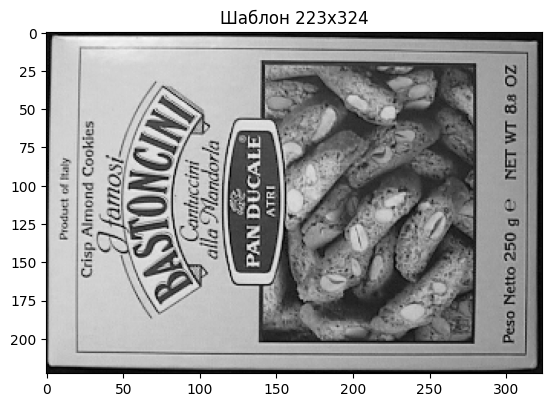

In [106]:
plt.imshow(img1, cmap='gray')
plt.title('Шаблон %dx%d' % img1.shape);

Text(0.5, 1.0, 'Сцена 384x512')

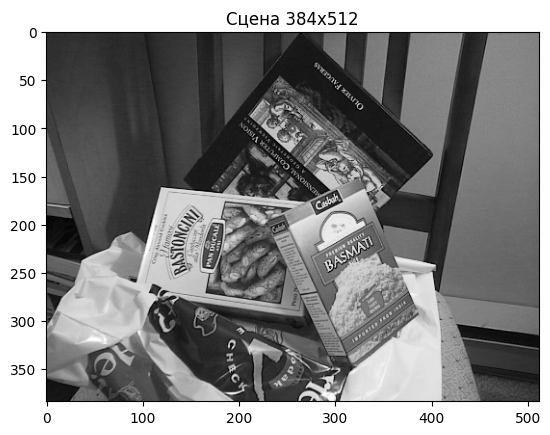

In [107]:
plt.imshow(img2, cmap='gray')
plt.title('Сцена %dx%d' % img2.shape)

Ищем характерные точки и вычисляем для них дескрипторы

In [108]:
# https://en.wikipedia.org/wiki/Oriented_FAST_and_rotated_BRIEF
# инициализируем детектор точек
orb = cv2.ORB_create()

# запускаем поиск точек и вычисление дескрипторов
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

Отображаем найденные характерные точки

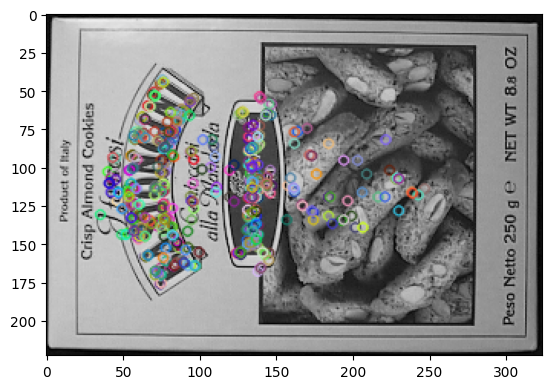

In [109]:
img1_kp = cv2.drawKeypoints(img1, kp1, np.zeros_like(img1))
plt.imshow(img1_kp)

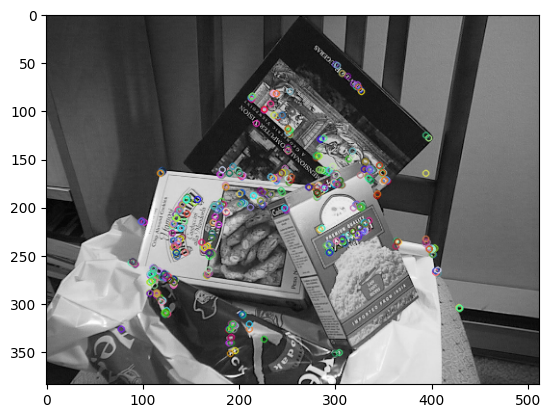

In [110]:
img2_kp = cv2.drawKeypoints(img2, kp2, np.zeros_like(img1))
plt.imshow(img2_kp)

Ищем соответствия между шаблоном и сценой

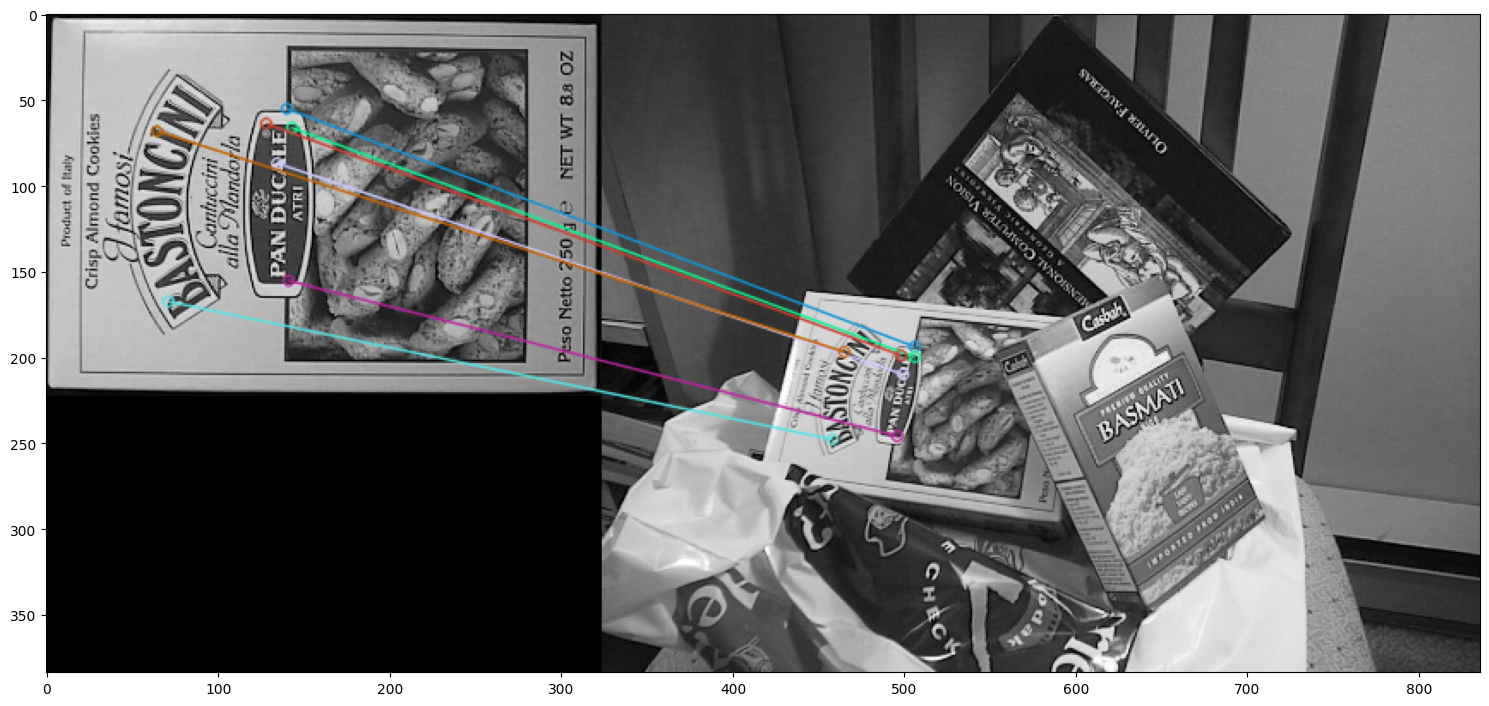

(<matplotlib.image.AxesImage at 0x13c3fa8a810>, None)

In [111]:
# матчинг полным перебором - brute force matching
# мера расстояния - расстояние Хэмминга (количество несовпадающих компонент)
bf = cv2.                          (cv2.NORM_HAMMING)

# матчинг
matches = bf.match(des1, des2)

# сортируем результат по убыванию расстояния
matches = sorted(matches, key = lambda x: x.distance)

# выводим 10 лучших совпадений
img3 = np.zeros_like(img2)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:7], img3, flags=2)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(img3),plt.show()

# Часть 4: Поиск похожих изображений - Content Based Image Retrieval (CBIR)
----

__Постановка задачи__
– картинки могут быть похожи по-разному
– мета теги;
– время создания;
– цвет;
– изображения с похожими предметами


![](./../src/imgs/cbir.png)

Подход:

– необходимо определиться с критерием поиска;
– от критерия поиска зависит способ выделения признаков изображения.

Выделение признаков изображения:
- нас интересуют признаки, которые описывают изображение в целом:
    - гистограммы цветов в пространстве HSV;
    - гистограммы градиентов
- Признаки можно считать как по всему изображению
- Альтернативный способ: разбить изображение на области и посчитать признаки для каждой области отдельно, и затем объединить результат


![](./../src/imgs/Img_features.png)


### Выделение признаков изображения:

![](./../src/imgs/feat_extract.png)


### Архитектура:

![](./../src/imgs/architecture.png)

In [112]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [113]:
class ColorDescriptor:

    def __init__(self, bins):
        # количество сегментов по y, x и channel
        self.bins = bins

    def describe(self, image):
        """ Вычисляем дескриптор изображения """

        features = []  # результирующий вектор дескриптора

        # переводим исходное изображение из цветового пространства BGR в HSV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        (h, w) = image.shape[:2]  # размеры изображения
        (cX, cY) = (int(w * 0.5), int(h * 0.5))  # координаты центра изображения

        # делим изображение на четыре равные части
        # и вычисляем координаты сегментов
        segments = [(0, cX, 0, cY),
                    (cX, w, 0, cY),
                    (cX, w, cY, h),
                    (0, cX, cY, h)]

        # готовим маску в виде эллипса для выделения
        # дескрипторов центральной части изображения
        (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        ellip_mask = np.zeros(image.shape[:2], dtype = np.uint8)
        cv2.ellipse(ellip_mask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)

        # итерируем по четырем сегментам и вычисляем дескрипторы
        for (startX, endX, startY, endY) in segments:
            # формируем маску сегмента
            corner_mask = np.zeros(image.shape[:2], dtype = np.uint8)
            cv2.rectangle(corner_mask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(corner_mask, ellip_mask)  # вычитаем пересечение с эллипсом

            # строим цветовую гистограмму с учетом маски сегмента
            hist = self.histogram(image, corner_mask)
            features.extend(hist)

        # вычисляем гистограму для центральной области
        hist = self.histogram(image, ellip_mask)
        features.extend(hist)

        # возвращаем вектор полученный вектор дескрипторов
        return features

    def histogram(self, image, mask):
        """ Вычисляет гистограмму в области, заданной маской """

        # задаем диапазоны изменений по каналам
        ranges = [0, 180,  # Hue
                  0, 256,  # Saturation
                  0, 256]  # Value

        # вычисляем 3D гистограмму (x, y, channel)
        hist = cv2.calcHist([image], [0, 1, 2], mask,
                            self.bins, ranges = ranges)

        # нормируем гистограмму
        hist = cv2.normalize(hist, np.zeros_like(hist)).flatten()

        return hist

Вычисляем дескрипторы для базы изображений

In [114]:
import glob

index = []   # имена фалов
index_features = []  # дескрипторы изображений

# получаем список файлов для индексации
files = list(glob.glob('./../data/inria/*.jpg'))

# инициализируем объект для вычисления дескрипторов
cd = ColorDescriptor((8, 12, 3))

for path in files[:25]:
    # сохраняем идентификатор изображения в массив
    image_id = path[path.rfind('/') + 1:]
    index.append(image_id)

    # загружаем изображение
    image = cv2.imread(path)

    # вычисляем и сохраняем дескрипторы
    features = cd.describe(image)
    index_features.append(features)

index_features = np.array(index_features)

In [115]:
index_features.shape

(12, 1440)

Определяем меру расстояния между дескрипторами

In [116]:
def chi2_distance(histA, histB, eps = 1e-10):
    # мера расстояния chi-квадрат
    d = 0.5 * np.sum([((a - b) ** 2) # / (a + b + eps)
                      for (a, b) in zip(histA, histB)])
    return d

In [117]:
def rank(query_features, index_features):
    # вычисляем расстояние до изображения из базы
    result = np.zeros(len(index_features))
    for i in range(len(index_features)):
        result[i] = chi2_distance(query_features, index_features[i])
    return result

Формируем запрос и выводим похожие изображения

In [118]:
# загружаем изображение для поиска похожих
query = cv2.imread('./../data/inria/105000_sm.jpg')

# получаем фичи для изображения запроса
query_features = cd.describe(query)

# ранжируем резльтат с учетом метрики расстояния
distance = rank(query_features, index_features)

# сортируем индексы по расстоянию
indices = np.argsort(distance)

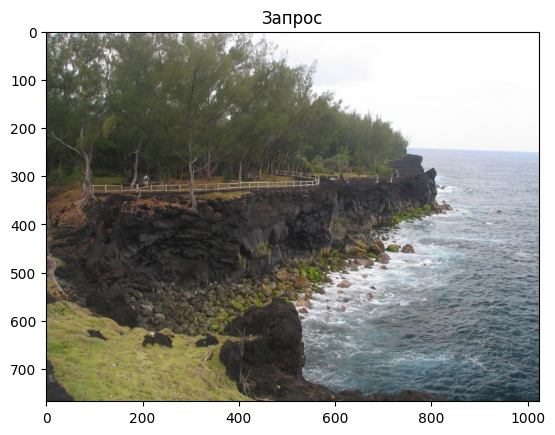

In [119]:
# изображение запроса
plt.imshow(cv2.cvtColor(query, cv2.COLOR_BGR2RGB))
plt.title('Запрос');

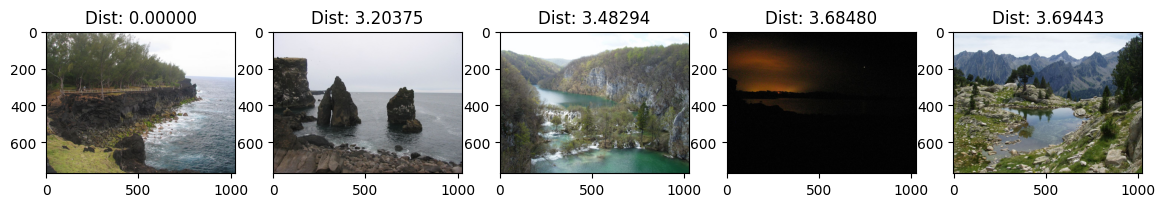

In [120]:
# выводим топ 5 самых близких изображений
fig = plt.figure(figsize=(20, 10))
for i, idx in enumerate(indices[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    img = cv2.imread(files[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Dist: %.5f' % distance[idx])

# Полезные материалы:

1. [Facebook Faiss: A library for efficient similarity search](https://github.com/facebookresearch/faiss/wiki/)
2. [Fast Lookups of Cosine and Other Nearest Neighbors](https://pypi.org/project/FALCONN/) - Довольно старая но полезная библиотека
3. [Eigenface](https://en.wikipedia.org/wiki/Eigenface)
4. [Computer Vision: Algorithms and Applications, 2nd ed.](http://szeliski.org/Book/)
5. [OpenCV: Feature Detection and Description](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html)
6. [OpenCV-Python Tutorials](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_tutorials.html)
7. [CBIR Engines](https://en.wikipedia.org/wiki/List_of_CBIR_engines)